In [1]:
from fdint import *
import numpy as np
import matplotlib.pyplot as plt

C_alpha_neutrino_sq=1.5625
C_A_sigma_0=1.05989679136e-20
C_me2_c3_ev=8.71002308255
C_hc3_ev=1.90589514992e-12
C_amu=1.66053886e-24
R_CONV =7.97315453692e-24
Q_CONV= 1.42134688491e-56
rho_gf=  1.61887093132742E-18
inv_rho_gf=  6.17714470405638E+17
C_fine_struct=0.00729735252051
C_sigma_0_cl=5.2763472608e-34
C_me2_c4=2.61119922915e+11
C_hc_ev=0.000123984197386


epsgf=1.11265005605362e-21
inv_epsgf=8.98755178736818e20

from scipy.interpolate import interpn
# normal stuff
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table, Column, MaskedColumn
import h5py
import scipy as scipy
from scipy import integrate
import glob

import matplotlib as mpl
%matplotlib inline

# set some global options

plt.rcParams['figure.figsize'] = (6,5)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.borderpad'] = 0.1
plt.rcParams['legend.labelspacing'] = 0.1
plt.rcParams['legend.handletextpad'] = 0.1
plt.rcParams['font.family'] = 'stixgeneral'
plt.rcParams['font.size'] = 16


In [2]:
#eos table location
f = h5py.File('../../../noble_harm_repo/test_optimize/harm3d_old/stage/sphere_plasmon/SLy4_3335_rho391_temp163_ye66.h5', 'r')

In [3]:
#reading the table data
logrho_new_grid,temp_new_grid, ye_new_grid=np.meshgrid(f['logrho'],f['logtemp'], f['ye'])
logrho_new_grid=logrho_new_grid+np.log10(1.61887093132742e-18)
entropy_new_grid=f['entropy'][()]
mu_e_new_grid=f['mu_e'][()]
mu_p_new_grid=f['mu_p'][()]
mu_n_new_grid=f['mu_n'][()]
mu_hat_new_grid=f['muhat'][()]
press_new_grid=10**(f['logpress'][()]+ np.log10(1.80123683248503e-39))
eps_new_grid=(10**(f['logenergy'][()])-f['energy_shift'][()])*1.11265005605362e-21
rho_unit_new_grid=10**(f['logrho'][()] + np.log10(1.61887093132742e-18))



In [4]:
#this functions will be used later, they solve the temperature given a rho, ye, eps

def funct_for_solve_for_t(temp,eps,rho, ye):
    return eps-interpn((f['ye'].value,10**f['logtemp'][()],rho_unit_new_grid), eps_new_grid, (ye,temp,rho))
from scipy.optimize import newton

def t_as_f_eps(eps, rho, ye):
    temp_init=1.
    root = newton(funct_for_solve_for_t, temp_init, maxiter=10000, args=(eps,rho,ye))
    return root

In [6]:
#from here on, there are functions that calculate the R, Q analitically 

def get_R_beta_antinu(ye0, t, u0, rho0, temp_in):
    
    temp0=t_as_f_eps(u0/(1/1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)
    
    
    temp_ev=temp0*1e6
    
    mu_hat=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_hat_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_e=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_e_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_p=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_p_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_n=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_n_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    
    eta_mu_hat=mu_hat/temp0
    eta_mu_e=mu_e/temp0
    eta_mu_p=mu_p/temp0
    eta_mu_n=mu_n/temp0
    eta__nu_e = -(mu_e/temp0 - mu_hat/temp0)
    
    
    if ye0<0.5:
        Y_np = ((2.0 * ye0 - 1.0) / (np.exp(-eta_mu_hat) - 1.0))
    else:
        Y_np=1.-ye0
    

    fermi_int=fdk(k=4,phi=-eta_mu_e)
    energy_moment = (8.0 * np.pi) * ((temp_ev**5.) / C_hc3_ev) * fermi_int


    fermi_int_order_5 = fdk(k=5,phi=-eta_mu_e)
    fermi_int_order_4 = fdk(k=4,phi=-eta_mu_e)
    blocking_factor = 1.0 / (1.0 + np.exp(-((fermi_int_order_5 / fermi_int_order_4) - eta__nu_e)))
    

    
    R_beta=((1.0 + 3.0 * C_alpha_neutrino_sq) / 8.0) * (C_A_sigma_0 / (C_me2_c3_ev)) * rho0 * Y_np * energy_moment * blocking_factor


    return (R_beta[0])/rho0*C_amu


def get_Q_beta_antinu(ye0, t, u0, rho0, temp_in):
    
    temp0=t_as_f_eps(u0/(1/1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)

    temp_ev=temp0*1e6
    R_beta=get_R_beta_antinu(ye0, 0., u0,rho0, temp0)*rho0/C_amu
    
    mu_hat=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_hat_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_e=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_e_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_p=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_p_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_n=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_n_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    
    eta_mu_hat=mu_hat/temp0
    eta_mu_e=mu_e/temp0
    eta_mu_p=mu_p/temp0
    eta_mu_n=mu_n/temp0
    eta__nu_e = -(mu_e/temp0 - mu_hat/temp0)

    fermi_int = fdk(k=5,phi=-eta_mu_e)
    energy_moment_star =  (8.0 * np.pi) * (temp_ev**6 / C_hc3_ev) * fermi_int
    
    fermi_int = fdk(k=4,phi=-eta_mu_e)
    energy_moment_tilde = (8.0 * np.pi) * (temp_ev**5 / C_hc3_ev) * fermi_int
    
    #print -R_beta*energy_moment_star/energy_moment_tilde
    #print R_beta
    
    return -R_beta*energy_moment_star/energy_moment_tilde



In [7]:
def get_R_beta_nu(ye0, t, u0, rho0, temp_in):
    
    temp0=t_as_f_eps(u0/(1/1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)
    temp0=temp_in

    
    temp_ev=temp0*1e6

    mu_hat=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_hat_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_e=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_e_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_p=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_p_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_n=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_n_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    
    eta_mu_hat=mu_hat/temp0
    eta_mu_e=mu_e/temp0
    eta_mu_p=mu_p/temp0
    eta_mu_n=mu_n/temp0
    eta__nu_e = mu_e/temp0 - mu_hat/temp0
    
    #eta__nu_e=200
    #eta_mu_e=15
    
    
    if ye0>0.5:
        Y_pn = np.exp(-eta_mu_hat)*((2.0 * ye0 - 1.0) / (np.exp(-eta_mu_hat) - 1.0))
    else:
        Y_pn=ye0


    fermi_int=fdk(k=4,phi=eta_mu_e)
    energy_moment = (8.0 * np.pi) * ((temp_ev**5.) / C_hc3_ev) * fermi_int


    fermi_int_order_5 = fdk(k=5,phi=eta_mu_e)
    fermi_int_order_4 = fdk(k=4,phi=eta_mu_e)
    blocking_factor = 1.0 / (1.0 + np.exp(-((fermi_int_order_5 / fermi_int_order_4) - eta__nu_e)))



    R_beta=((1.0 + 3.0 * C_alpha_neutrino_sq) / 8.0) * (C_A_sigma_0 / (C_me2_c3_ev)) * rho0 * Y_pn * energy_moment * blocking_factor
    
    #fermi_int = fdk(k=2,phi=eta__nu_e)

    #neutrino_density= 4*np.pi* temperaturev*temperaturev*temperaturev/C_hc3_ev * fermi_int
    #t_inv=R_beta/neutrino_density
    #print R_beta
    return -(R_beta[0])/rho0*C_amu#, Q_beta


def get_Q_beta_nu(ye0, t, u0, rho0, temp_in):
    
    temp0=t_as_f_eps(u0/(1/1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)

    
    temp_ev=temp0*1e6
    R_beta=-get_R_beta_nu(ye0, 0., u0,rho0, temp0)*rho0/C_amu
    
    mu_hat=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_hat_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_e=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_e_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_p=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_p_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_n=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_n_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    
    eta_mu_hat=mu_hat/temp0
    eta_mu_e=mu_e/temp0
    eta_mu_p=mu_p/temp0
    eta_mu_n=mu_n/temp0
    eta__nu_e = mu_e/temp0 - mu_hat/temp0

    fermi_int = fdk(k=5,phi=eta_mu_e)
    energy_moment_star =  (8.0 * np.pi) * (temp_ev**6 / C_hc3_ev) * fermi_int
    
    fermi_int = fdk(k=4,phi=eta_mu_e)
    energy_moment_tilde = (8.0 * np.pi) * (temp_ev**5 / C_hc3_ev) * fermi_int
    
    return -R_beta*energy_moment_star/energy_moment_tilde

In [8]:
def R_plasmon(ye0, t, u0, rho0, temp_in):
    
    temp0=t_as_f_eps(u0/(1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)
    
    temp_ev=temp0*1e6
    
    mu_hat=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_hat_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_e=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_e_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_p=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_p_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_n=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_n_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    
    eta_mu_hat=mu_hat/temp0
    eta_mu_e=mu_e/temp0
    eta_mu_p=mu_p/temp0
    eta_mu_n=mu_n/temp0
    eta__nu_e = mu_e/temp0 - mu_hat/temp0
    eta__antinu_e = -(mu_e/temp0 - mu_hat/temp0)
    
    gamma_0 = 0.05565
    gamma = gamma_0 * np.sqrt((1.0 / 3.0) * (np.pi**2 + 3.0 *eta_mu_e**2))
    C_value = 0.9216
    
    neutrino_blocking_factor=1.0 / (1.0 + exp(-(1.0 + 0.5 * gamma**2 / (1.0 + gamma)) - eta__nu_e))
    anti_neutrino_blocking_factor=1.0 / (1.0 + exp(-(1.0 + 0.5 * gamma**2 / (1.0 + gamma)) - eta__antinu_e))
    
    
    R_plasmon=(np.pi**3 / (3.0 * C_fine_struct)) * C_value * (C_sigma_0_cl/ C_me2_c4) * (temp_ev**8 /C_hc_ev**6) *gamma**6 * np.exp(-gamma) * (1.0 + gamma) * neutrino_blocking_factor * anti_neutrino_blocking_factor
        
    return R_plasmon
def R_plasmon_for_ode(ye0, t, u0, rho0, temp_in):
    return 0.
    

def Q_plasmon(ye0, t, u0, rho0, temp_in):   
    
    temp0=t_as_f_eps(u0/(1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)
    
    temp_ev=temp0*1e6
    gamma_0 = 0.05565
    gamma = gamma_0 * np.sqrt((1.0 / 3.0) * (np.pi**2 + 3.0 *eta_mu_e**2))
    
    R_gamma=R_plasmon(ye0, t, u0, rho0, temp_in)
    
    Q_plasmon= temp_ev * (2.0 + ((gamma * gamma) / (1.0 + gamma))) * R_gamma
    return Q_plasmon

In [9]:
def R_ee(ye0, t, u0, rho0, temp_in):
    C_values = 2.3432
    
    temp0=t_as_f_eps(u0/(1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)
    
    temp_ev=temp0*1e6
    
    mu_hat=interpn((f['ye'][()],10**f['logtemp'].value,rho_unit_new_grid), mu_hat_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_e=interpn((f['ye'][()],10**f['logtemp'].value,rho_unit_new_grid), mu_e_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_p=interpn((f['ye'][()],10**f['logtemp'].value,rho_unit_new_grid), mu_p_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_n=interpn((f['ye'][()],10**f['logtemp'].value,rho_unit_new_grid), mu_n_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    
    eta_mu_hat=mu_hat/temp0
    eta_mu_e=mu_e/temp0
    eta_mu_p=mu_p/temp0
    eta_mu_n=mu_n/temp0
    eta__nu_e = mu_e/temp0 - mu_hat/temp0
    eta__antinu_e = -(mu_e/temp0 - mu_hat/temp0)
    
    
    fermi_int = fdk(k=3,phi=eta_mu_e) 
    electron_energy_moment=(8.0 * C_pi) * (temp_ev**4 / C_hc3_ev) * fermi_int
    
    fermi_int = fdk(k=3,phi=-eta_mu_e) 
    positron_energy_moment= (8.0 * np.pi) * (temp_ev**4 / C_hc3_ev) * fermi_int
    
    
    electron_fermi_int_order_4 = fdk(k=4,phi=eta_mu_e) 
    electron_fermi_int_order_3 = fdk(k=3,phi=eta_mu_e)
    positron_fermi_int_order_4 = fdk(k=4,phi=-eta_mu_e)
    positron_fermi_int_order_3 = fdk(k=3,phi=-eta_mu_e)
    
    neutrino_blocking_factor=1.0 / (1.0 + np.exp(-((0.5 * (electron_fermi_int_order_4 / electron_fermi_int_order_3))+ (0.5 * (positron_fermi_int_order_4 / positron_fermi_int_order_3)) - eta__nu_e)))
    anti_neutrino_blocking_factor =1.0 / (1.0 + np.exp(-((0.5 * (electron_fermi_int_order_4 / electron_fermi_int_order_3))+ (0.5 * (positron_fermi_int_order_4 / positron_fermi_int_order_3)) - eta__antinu_e)))


    R_ee= (C_values / 36.0) * (C_sigma_0_cl/ C_me2_c4) *electron_energy_moment * positron_energy_moment * neutrino_blocking_factor * anti_neutrino_blocking_factor 
    return R_ee

def R_ee_for_ode(ye0, t, u0, rho0, temp_in):
    return 0.

def Q_ee(ye0, t, u0, rho0, temp_in):
        
    temp0=t_as_f_eps(u0/(1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/(rho0/inv_rho_gf), rho0/inv_rho_gf, ye0)
    
    temp_ev=temp0*1e6
    
    mu_hat=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_hat_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_e=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_e_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_p=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_p_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    mu_n=interpn((f['ye'][()],10**f['logtemp'][()],rho_unit_new_grid), mu_n_new_grid, (ye0,temp0,rho0/inv_rho_gf))
    
    eta_mu_hat=mu_hat/temp0
    eta_mu_e=mu_e/temp0
    eta_mu_p=mu_p/temp0
    eta_mu_n=mu_n/temp0
    eta__nu_e = mu_e/temp0 - mu_hat/temp0
    eta__antinu_e = -(mu_e/temp0 - mu_hat/temp0)
    
    
    R_ee=R_ee(ye0, t, u0, rho0, temp_in)
    
    
    Q_ee=R_ee * energy_moment_average/(ord_electron_energy_moment*ord_positron_energy_moment)
    return Q_ee

In [10]:
#time array to integrate
t_s = np.linspace(0, 5, 100)

In [11]:
#ode solvers (see murguia-berthier harm_nuc eq 59, 60)

def ode_to_solve_beta_nu(y,t,rho0,temp0):
    ye0,u0=y
    Q_tot=get_Q_beta_nu(ye0, t, u0, rho0, temp0)
    #print( Q_tot)
    R_tot=get_R_beta_nu(ye0, t, u0, rho0, temp0)
    #print(R_tot)
    dydt = [R_tot, Q_tot]
    return dydt

def ode_to_solve_beta_antinu(y,t,rho0,temp0):
    ye0,u0=y
    Q_tot=get_Q_beta_antinu(ye0, t, u0, rho0, temp0)
    #print Q_tot
    R_tot=get_R_beta_antinu(ye0, t, u0, rho0, temp0)
    #print R_tot
    dydt = [R_tot, Q_tot]
    return dydt


In [12]:
#here is where the eq. is solved

from scipy.integrate import odeint

#for antinue
rho0=1e-12
temp0=1
ye0=0.005
u0=interpn((f['ye'].value,10**f['logtemp'].value,rho_unit_new_grid), eps_new_grid, (ye0,temp0,rho0))*rho0

y0_antinu=[ye0,u0/1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21]
sol_tot_antinu= odeint(ode_to_solve_beta_antinu, y0_antinu, t_s, args=(rho0*inv_rho_gf, temp0))

<ipython-input-12-337907fee1f2>:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  u0=interpn((f['ye'].value,10**f['logtemp'].value,rho_unit_new_grid), eps_new_grid, (ye0,temp0,rho0))*rho0
<ipython-input-4-cc4003a66bc6>:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eps-interpn((f['ye'].value,10**f['logtemp'][()],rho_unit_new_grid), eps_new_grid, (ye,temp,rho))


In [13]:
#for nu
rho0=1e-12
temp0=1
ye0=0.5
u0=6.717695e-13 
u0=interpn((f['ye'].value,10**f['logtemp'].value,rho_unit_new_grid), eps_new_grid, (ye0,temp0,rho0))*rho0

<ipython-input-13-0b1d85e3ff04>:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  u0=interpn((f['ye'].value,10**f['logtemp'].value,rho_unit_new_grid), eps_new_grid, (ye0,temp0,rho0))*rho0


In [14]:
t_as_f_eps_vec=np.vectorize(t_as_f_eps)

<ipython-input-4-cc4003a66bc6>:2: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return eps-interpn((f['ye'].value,10**f['logtemp'][()],rho_unit_new_grid), eps_new_grid, (ye,temp,rho))


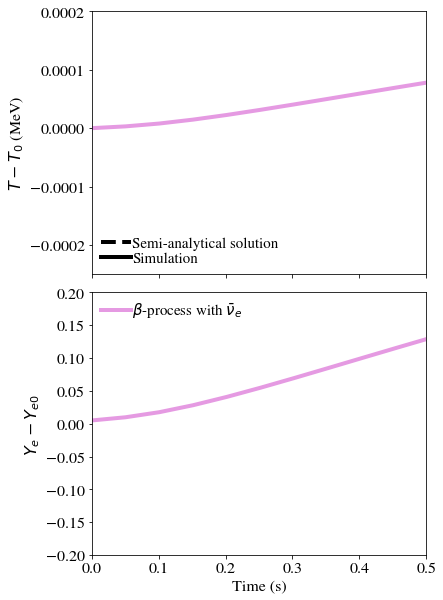

In [15]:
plt.figure(figsize=(6,10))

ax1=plt.subplot(211)
plt.plot(t_s,t_as_f_eps_vec(sol_tot_antinu[:,1]/(1/1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/rho0,rho0, sol_tot_antinu[:,0])-1, c='orchid', lw=4, alpha=0.7,label='')# label=r'$\beta$-process with $\bar{\nu}_{\rm e}$')
#plt.plot(time_array_antinu[temp_array_antinu!=0.]*4.92513293223396E-06, temp_array_antinu[temp_array_antinu!=0.]-1, '--', c='purple', lw=4,label='')

#plt.plot(t_s,t_as_f_eps_vec(sol_tot_nu[:,1]/(1/1.60218e-12*inv_rho_gf/5.02916918125126E-34/1.11265005605362E-21)/rho0,rho0, sol_tot_nu[:,0])-1, c='skyblue', lw=4, alpha=0.7,label='')#, label=r'$\beta$-process with $\nu_{\rm e}$')
#plt.plot(time_array_nu[temp_array_nu!=0.]*4.92513293223396E-06, temp_array_nu[temp_array_nu!=0.]-1, '--', c='blue', lw=4,label='')

plt.plot(1,1,'--', c='black', lw=4, label='Semi-analytical solution')
plt.plot(1,1,'-', c='black', lw=4, label='Simulation')
#plt.set_xticklabels([])
#plt.xlabel('Time (s)')
plt.ylabel(r'$T-T_0$ (MeV)')
plt.legend(fontsize=15, loc=3)
plt.xlim(0,0.5)
#
plt.ylim(0.99975-1,1.0002-1)

ax2=plt.subplot(212)
plt.plot(t_s, sol_tot_antinu[:,0], c='orchid', lw=4, alpha=0.7, label=r'$\beta$-process with $\bar{\nu}_{e}$')
#plt.plot(time_array_antinu[ye_array_antinu!=0]*4.92513293223396E-06, ye_array_antinu[ye_array_antinu!=0], '--', c='purple', lw=4,label='')

#plt.plot(t_s, sol_tot_nu[:,0]-0.5, c='skyblue', lw=4, alpha=0.7, label=r'$\beta$-process with $\nu_{ e}$')
#plt.plot(time_array_nu[ye_array_nu!=0]*4.92513293223396E-06, ye_array_nu[ye_array_nu!=0]-0.5, '--', c='blue', lw=4,label='')



plt.xlabel('Time (s)')
plt.ylabel(r'$Y_{e}-Y_{e0}$')
plt.xlim(0,0.5)
plt.ylim(-0.2,0.2)
plt.legend(loc=2, fontsize=15)
plt.subplots_adjust(hspace=0.07)

ax1.tick_params(labelbottom=False)    
#plt.show()
#plt.savefig('beta_process.pdf', dpi=150, bbox_inches='tight')